In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import skew, kurtosis
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Data Preparation

In [2]:
df1 = pd.read_csv("Dataset1_TranscriptMahasiswa.csv", sep=";", dtype={"NIM" :"object", "NAMA_MK" : "string"})
df2 = pd.read_csv("Dataset2_EvaluasiDosenPerMK.csv", sep=";", decimal=",")

## Df1 -> Df3

In [3]:
df1['KODE_MK'][df1['NAMA_MK'].isnull()].unique()

# fill Nama_MK yang null

df1["NAMA_MK"] = df1["NAMA_MK"].fillna("Tugas Akhir") # Kebetulan yang null cuman SI863

# add kode MK ke Nama_MK

for i in df1.index:  
    if df1.at[i, "KODE_MK"] not in df1.at[i, "NAMA_MK"].split(" ") : 
        df1.at[i, "NAMA_MK"] = df1.at[i, "KODE_MK"] + " " + df1.at[i, "NAMA_MK"]

        indeks = ["A", "A-", "B+", "B", "B-", "C+", "C", "D", "E", "F"]
bobot = [4, 3.7, 3.3, 3.0, 2.7, 2.3, 2.0, 1.0, 0, 0]
ranges = [[100, 85], [84.99, 80], [79.99, 75], [74.99, 70], [69.99, 65], [64.99, 60], [59.99, 55], [54.99, 45], [44.99,0]]

# fill grade yang null

for i in df1.index:
    for j in ranges:
        if j[1] <= df1.at[i, "NILAI"] <= j[0]:
            df1.at[i, "GRADE"] = indeks[ranges.index(j)]

# menambah total bobot = bobot x sks

for i in df1.index:
    for j in indeks:
        if df1.at[i, "GRADE"] == j:
            df1.at[i, "BOBOT"] = bobot[indeks.index(j)]
            df1.at[i, "TOTAL_BOBOT"] = df1.at[i, "BOBOT"] * df1.at[i, "SKS"]

# fill null NILAI

df1["NILAI"] = df1["NILAI"].fillna(0)
df1[df1['NILAI'].isnull()]

# dropping duplicate MK
df1 = df1.drop_duplicates(subset=['KODE_MK', 'NIM'], keep='last')

In [4]:
# Pembuataan Dataframe dengan grouping data berdasarkan NIM
# Perhitungan SKS
df3_ = pd.DataFrame(df1.groupby(["NIM"])["SKS"].sum().reset_index())
# Perhitungan Grade
df3__ = pd.DataFrame(df1.loc[(df1["GRADE"] == "D") | (df1["GRADE"] == "E") | (df1["GRADE"] == "F")].groupby("NIM")["GRADE"].sum().reset_index())
# Perhitungan Total Bobot
df3___ = pd.DataFrame((df1.groupby("NIM")["TOTAL_BOBOT"].sum().reset_index()))
# Perhitungan jumlah semester
df3____ =  pd.DataFrame((((df1.groupby("NIM")["SEMESTER"].max() - df1.groupby("NIM")["SEMESTER"].min()) / 100).reset_index()))
# Penambahan Nilai Rata-rata 
df3_____ =  pd.DataFrame((((df1.groupby("NIM")["NILAI"].mean().reset_index()))))

# Merging Dataframe
df3 = pd.merge(df3_, df3__, how="left", on=["NIM"])
df3 = pd.merge(df3, df3___, how="left", on=["NIM"])
df3 = pd.merge(df3, df3____, how="left", on=["NIM"])
df3 = pd.merge(df3, df3_____, how="left", on=["NIM"])
df3["GRADE"] = df3["GRADE"].fillna("")

df3.rename(columns = {"GRADE" : "FAILED_GRADE", "SKS" : "TOTAL_SKS", "SEMESTER" : "WAKTU_KULIAH", "NILAI" : "NILAI_RATA-RATA"}, inplace = True)

# Perhitungan IPK
for i in df3.index:
    df3.at[i ,"IPK"] = df3.at[i, "TOTAL_BOBOT"] / df3.at[i, "TOTAL_SKS"]
    if df3.at[i, "WAKTU_KULIAH"] - int(df3.at[i, "WAKTU_KULIAH"]) != 0: 
        df3.at[i, "WAKTU_KULIAH"] = int(df3.at[i, "WAKTU_KULIAH"]) + 0.5

# Kolom :
# Hasil : TIDAK LULUS, LULUS, TEPAT WAKTU

for i in df3.index:
    if df3.at[i, "TOTAL_SKS"] >= 144 and df3.at[i, "FAILED_GRADE"] == "" and df3.at[i, "IPK"] >= 2.5:
        if df3.at[i, "WAKTU_KULIAH"] <= 4:
            df3.at[i, "HASIL"] = "Lulus Tepat Waktu"
        else: 
            df3.at[i, "HASIL"] = "Lulus Telat"
    else:  
        df3.at[i, "HASIL"] = "Tidak Lulus"

In [5]:
df3

,NIM,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU_KULIAH,NILAI_RATA-RATA,IPK,HASIL
0,00000008429,145,D,474.5,3.5,77.882353,3.272414,Tidak Lulus
1,00000008455,136,DD,416.2,3.5,74.551020,3.060294,Tidak Lulus
2,00000008481,127,DDDEEED,313.6,3.5,65.934783,2.469291,Tidak Lulus
3,00000008631,145,,519.3,3.0,83.294118,3.581379,Lulus Tepat Waktu
4,00000008684,145,,512.1,3.0,82.352941,3.531724,Lulus Tepat Waktu
...,...,...,...,...,...,...,...,...
765,14110310095,145,DD,469.9,4.0,76.923077,3.240690,Tidak Lulus
766,14110310098,145,D,464.1,4.0,75.365385,3.200690,Tidak Lulus
767,14110310101,138,,438.4,4.5,75.673469,3.176812,Tidak Lulus
768,14110310102,133,EEE,362.2,4.5,68.687500,2.723308,Tidak Lulus


## Df2 -> Df4

In [6]:
# nilai rata-rata dari tiap matakuliah
df4 = pd.DataFrame(df2.groupby(["TAHUN", "MATAKULIAH"])["NILAI"].mean().reset_index())
df4.rename(columns = {"NILAI" : "NILAI_RATA-RATA"}, inplace = True)

# Modelling

## Sampling and Data Splitting

In [21]:
X = df3[['TOTAL_SKS', 'IPK', 'WAKTU_KULIAH']]
y = df3['HASIL']

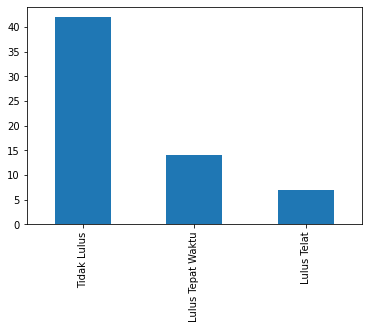

In [38]:
rus = RandomUnderSampler(sampling_strategy={'Tidak Lulus' : 42, 'Lulus Telat' : 7, 'Lulus Tepat Waktu' : 14})
X_rus, y_rus = rus.fit_resample(X, y) 

y_rus.value_counts().plot(kind="bar")

# split dataset

X_train, X_val, y_train, y_val = train_test_split(X_rus, y_rus, test_size=0.25, shuffle=True, random_state=42)

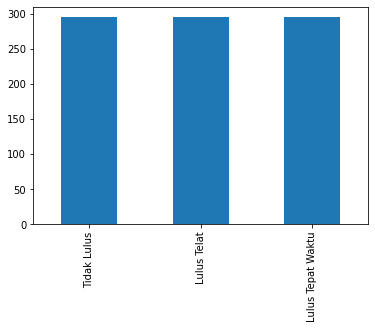

In [41]:
ros = RandomOverSampler(sampling_strategy='all')
rus = RandomUnderSampler(sampling_strategy={'Tidak Lulus' : 295, 'Lulus Telat' : 295, 'Lulus Tepat Waktu' : 295})

X_ros, y_ros = ros.fit_resample(X, y) 
X_rus, y_rus = rus.fit_resample(X_ros, y_ros) 

y_rus.value_counts().plot(kind="bar")

# split dataset

X_train, X_val, y_train, y_val = train_test_split(X_rus, y_rus, test_size=0.25, shuffle=True, random_state=42)

<AxesSubplot:>

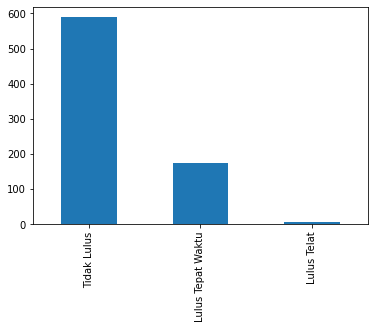

In [42]:
y.value_counts().plot(kind="bar")

## Model Evaluation

In [53]:
np.random.seed(42)

# spot-check algorithm
models = [('LR', LogisticRegression()),
         ('CART', DecisionTreeClassifier()),
         ('RF', RandomForestClassifier()),
         ('SVC', SVC()),
         ('KNN', KNeighborsClassifier())]

models_name = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    models_name.append(name)
    results.append(cv_score)
    print(f'{name} \t | cv_score_mean: {cv_score.mean()} \t | cv_score_std: {cv_score.std()}')

c:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

LR 	 | cv_score_mean: 0.8823529411764706 	 | cv_score_std: 0.016104190425386588
CART 	 | cv_score_mean: 0.923076923076923 	 | cv_score_std: 0.009774872848277332
RF 	 | cv_score_mean: 0.9260935143288084 	 | cv_score_std: 0.012974849573216632
SVC 	 | cv_score_mean: 0.5490196078431372 	 | cv_score_std: 0.030763315315793602
KNN 	 | cv_score_mean: 0.9215686274509803 	 | cv_score_std: 0.00929775867717796


<AxesSubplot:>

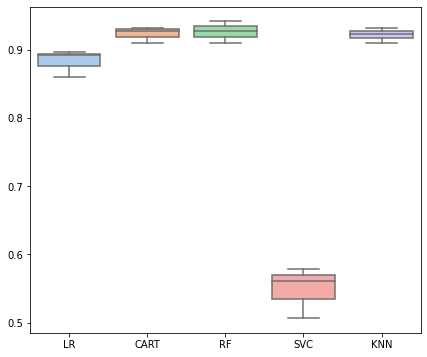

In [44]:
# boxplot comparing models
results_df = pd.DataFrame(np.asarray(results).T, columns=models_name)

plt.figure(figsize=(7,6))
sns.boxplot(data=results_df, palette='pastel')

# Pertanyaan Soal
1. Menemukan seberapa besar pengaruh mata kuliah yang diikuti dan atau kualitas dosen mata kulah untuk kelulusan tepat waktu mahasiswa.
2. Melakukan analisis dan faktor pengaruh kualitas dosen melalui pencapaian nilai akhir mahasiswa yang digunakan sebagai prediksi terhadap kelulusan tepat waktu mahasiswa,
3. Melakukan analisis dan menetapkan penemuan faktor-faktor yang sangat berpengaruh terhadap waktu studi mahasiswa dan kesimpulan dari prediksi pengaruh kualitas dosen terhadap kelulusan mahasiswa tepat waktu
4. Membuat prediksi tren kelulusan tepat waktu mahasiswa Program Studi Sistem Informasi (sesuai dengan data yang digunakan).

# Modeling ketepatan waktu lulus

In [54]:
df5 = df3[df3['HASIL'] == 'Lulus'].reset_index()
df5

,index,NIM,TOTAL_SKS,FAILED_GRADE,TOTAL_BOBOT,WAKTU_KULIAH,NILAI_RATA-RATA,IPK,HASIL


In [55]:
# menambahkan kolom jenis kelulusan

for i in range(len(df5)):
    if df5.loc[i, 'WAKTU_KULIAH'] <= 4:
        df5.loc[i, 'TIPE'] = 'Tepat Waktu'
    else:
        df5.loc[i, 'TIPE'] = 'Telat'
        
df5.sample(10)

ValueError: a must be greater than 0 unless no samples are taken

In [25]:
df5['TIPE'].value_counts().plot(kind='bar', width=0.4)
plt.xticks(rotation=0)
plt.title('Jumlah Jenis Kelulusan Mahasiswa')
plt.show()

NameError: name 'df5' is not defined

In [41]:
X = df5[['TOTAL_SKS', 'IPK', 'WAKTU_KULIAH']]
y = df5['TIPE']

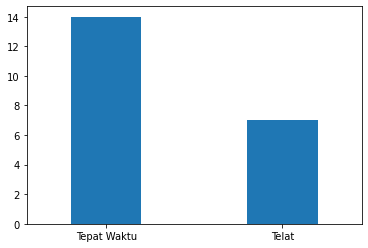

In [52]:
rus = RandomUnderSampler(sampling_strategy=0.5)
X_rus, y_rus = rus.fit_resample(X, y) 

y_rus.value_counts().plot(kind="bar", width=0.4)
plt.xticks(rotation=0)

# split dataset

X_train, X_val, y_train, y_val = train_test_split(X_rus, y_rus, test_size=0.25, shuffle=True, random_state=42)

In [53]:
np.random.seed(42)

# spot-check algorithm
models = [('LR', LogisticRegression()),
         ('CART', DecisionTreeClassifier()),
         ('RF', RandomForestClassifier()),
         ('SVC', SVC()),
         ('KNN', KNeighborsClassifier())]

models_name = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    models_name.append(name)
    results.append(cv_score)
    print(f'{name} \t | cv_score_mean: {cv_score.mean()} \t | cv_score_std: {cv_score.std()}')

LR 	 | cv_score_mean: 0.8666666666666667 	 | cv_score_std: 0.1885618083164127
CART 	 | cv_score_mean: 1.0 	 | cv_score_std: 0.0
RF 	 | cv_score_mean: 1.0 	 | cv_score_std: 0.0
SVC 	 | cv_score_mean: 0.7333333333333334 	 | cv_score_std: 0.09428090415820638
KNN 	 | cv_score_mean: 0.8666666666666667 	 | cv_score_std: 0.1885618083164127


<AxesSubplot:>

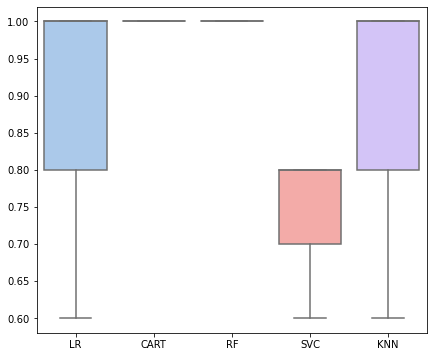

In [54]:
# boxplot comparing models
results_df = pd.DataFrame(np.asarray(results).T, columns=models_name)

plt.figure(figsize=(7,6))
sns.boxplot(data=results_df, palette='pastel')

# testing oversample

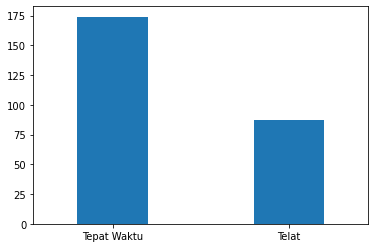

In [59]:
ov = RandomOverSampler(sampling_strategy=0.5)
X_ov, y_ov = ov.fit_resample(X, y)

y_ov.value_counts().plot(kind="bar", width=0.4)
plt.xticks(rotation=0)

# split dataset

X_train, X_val, y_train, y_val = train_test_split(X_ov, y_ov, test_size=0.25, shuffle=True, random_state=42)

In [60]:
np.random.seed(42)

# spot-check algorithm
models = [('LR', LogisticRegression()),
         ('CART', DecisionTreeClassifier()),
         ('RF', RandomForestClassifier()),
         ('SVC', SVC()),
         ('KNN', KNeighborsClassifier())]

models_name = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    models_name.append(name)
    results.append(cv_score)
    print(f'{name} \t | cv_score_mean: {cv_score.mean()} \t | cv_score_std: {cv_score.std()}')

LR 	 | cv_score_mean: 1.0 	 | cv_score_std: 0.0
CART 	 | cv_score_mean: 1.0 	 | cv_score_std: 0.0
RF 	 | cv_score_mean: 1.0 	 | cv_score_std: 0.0
SVC 	 | cv_score_mean: 0.6461538461538462 	 | cv_score_std: 0.0
KNN 	 | cv_score_mean: 1.0 	 | cv_score_std: 0.0
